In [ ]:
pip install qiskit

In [ ]:
pip install qiskit_nature

In [ ]:
pip install PySCF

In [55]:
from qiskit import Aer
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

from qiskit_nature.transformers import ActiveSpaceTransformer
from qiskit_nature.algorithms import GroundStateEigensolver, BOPESSampler
from qiskit.algorithms import NumPyMinimumEigensolver

from qiskit.utils import QuantumInstance, algorithm_globals

from qiskit_nature.circuit.library.ansatzes import UCCSD
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit.circuit.library import TwoLocal

from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP

from functools import partial as apply_variation_to_atom_pair
import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, assemble, transpile

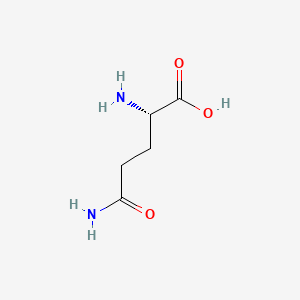

Glutamine molecule is the key protease in SARS-Cov-2. To simulate the whole molecule, 40+ qubits and several weeks of computation time would be required -- unfeasible with current technology. 

However, by reducing the glutamine to NH₂C, we are able to simulate the binding of glutamine with a protease inhibitor, effectively achieving a speedup in the development of new SARS-Cov-2 vaccines.

National Center for Biotechnology Information. "PubChem Compound Summary for CID 5961, Glutamine" PubChem, https://pubchem.ncbi.nlm.nih.gov/compound/Glutamine. Accessed 30 January, 2022.

In [56]:
variation = Molecule.absolute_stretching

#Other types of molecular variation:
#molecular_variation = Molecule.relative_stretching
#molecular_variation = Molecule.absolute_bending
#molecular_variation = Molecule.relative_bending


# Actual molecule that's currently too large

#glutamine_molecule = Molecule(geometry=
#                              [['O', [-2.1389, 1.637, 0.5099]],
#                               ['O', [-2.6773, 0.2475, -1.1973]],
#                               ['O', [2.9039, 0.2551, 1.0351]],
#                               ['N', [-1.4789,  -1.8922, -0.0291]],
#                               ['N', [3.2441, 0.1932, -1.2385]],
#                               ['C', [0.1338, -0.2355, 0.8758]],
#                               ['C', [-1.3424, -0.6086, 0.659]],
#                               ['C', [1.0032,  -0.1458, -0.3839]],
#                               ['C', [-2.1158, 0.4356, -0.1257]],
#                               ['C', [2.4683, 0.1136, -0.1257]],
#                               ['H', [0.1904, 0.7236, -0.1051]],
#                               ['H', [0.5783, -0.9764, 1.4071]],
#                               ['H', [-0.18319, -0.7041, 1.5545]],
#                               ['H', [0.95,-1.0821, -0.9509]],
#                               ['H', [0.6339, 0.6568,-1.0331]],
#                               ['H', [-1.136,-1.8186,-0.9858]],
#                               ['H', [-2.4648,-2.142,-0.0988]],
#                               ['H', [2.856,0.078,-2.1693]],
#                               ['H', [4.2414,0.3697,-1.1781]],
#                               ['H', [-2.645,2.3081,0.0041]],
#                               ['C', [-1.4789, -1.8922, -1]]], # Carbon inhibitor
#                              charge=0, multiplicity=1)

specific_variation = apply_variation_to_atom_pair(variation, atom_pair=(4, 2))

# Modified version of glutamine
toy_glutamine = Molecule(geometry=
                        [['H', [-0.18319, -0.7041, 1.5545]],
                         ['H', [-1.136,-1.8186,-0.9858]],
                         ['N', [-1.4789,  -1.8922, -0.0291]],
                         ['C', [-1.3424, -0.6086, 0.659]],
                         ['C', [-0.5200, -1.9200, 0.000]]], # Carbon inhibitor
                          charge=3, multiplicity=1, degrees_of_freedom=[specific_variation])
# -1.4789, -1.8922, -1

In [57]:
import os
MAX_MEMORY = int (os.environ.get ('MAX_MEMORY', 80000))## Memory in MB
orbital_maker = PySCFDriver(molecule=toy_glutamine, unit=UnitsType.ANGSTROM, basis='sto3g', max_memory=MAX_MEMORY)
transformer = ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=2)
fermonic_hamiltonian = ElectronicStructureProblem(orbital_maker, [transformer])

# Parity mapper to reduce qubits required
fermonic_hamiltonian.second_q_ops()

#
fermions_to_q = QubitConverter(JordanWignerMapper())

Solve using hardware

In [58]:
hardware_trial = TwoLocal(num_qubits=5, rotation_blocks = ['rz'], entanglement_blocks = 'cx',
                                   entanglement='full', reps=3, skip_unentangled_qubits=True, skip_final_rotation_layer=True)    

In [59]:
from qiskit.opflow.gradients import Gradient
algorithm_globals.random_seed = 50

optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]

e_result = []
for i, optimizers in enumerate(optimizers):
    
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    quantum_environment = QuantumInstance(Aer.get_backend('statevector_simulator'))
    vqe = VQE(ansatz=hardware_trial, optimizer=optimizers, callback=store_intermediate_result, quantum_instance=quantum_environment)
    
    ground_state = GroundStateEigensolver(fermions_to_q, vqe)
    e_result.append(BOPESSampler(gss=ground_state, bootstrap=False))
    
    res = ground_state.solve(fermonic_hamiltonian)
    if i == 0:
        print(" ========COBYLA======== \n")
        print(res)
    elif i == 1:
        print("\n \n ========L_BFGS_B======== \n")
        print(res)
    else:
        print("\n \n ========SLSQP======== \n")
        print(res)

total_number_of_parameters = len(hardware_trial._ordered_parameters)
print("Total number of adjustable parameters: ", total_number_of_parameters)

 ========COBYLA======== 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -186.593645874189
  - computed part:      0.0
  - ActiveSpaceTransformer extracted energy part: -186.593645874189
~ Nuclear repulsion energy (Hartree): 63.073340159141
> Total ground state energy (Hartree): -123.520305715048
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 0.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-43.17247517  -58.46755938  8.16172713]
 
  0: 
  * Electronic dipole moment (a.u.): [-35.69402272  -45.518517  5.6044376]
    - computed part:      [0.0  0.0  0.0]
    - ActiveSpaceTransformer extracted energy part: [-35.69402272  -45.518517  5.6044376]
  > Dipole moment (a.u.): [-7.47845245  -12.94904238  2.55728953]  Total: 15.17052007
                 (debye): [-19.00832832  -32.91317966  6.49998103]  Total: 38.55961221
 

 
 ========L_BFGS_B======== 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Har

In [60]:
e_s_result = []
for i, e_result in enumerate(e_result):
    e_s_result.append(e_result.sample(fermonic_hamiltonian, np.linspace(-0.5, 5, 30)))

Solve using Hartree-Fock approximation

In [61]:
molecule_info = fermonic_hamiltonian.molecule_data_transformed
mol_orbitals = molecule_info.num_molecular_orbitals
spin_orbitals = 2 * mol_orbitals
electrons_up_down = (
            molecule_info.num_alpha,
            molecule_info.num_beta,
        )
initial_state = HartreeFock(spin_orbitals, electrons_up_down, fermions_to_q)

chemistry_trial = UCCSD(
            fermions_to_q,
            electrons_up_down,
            spin_orbitals,
            initial_state=initial_state,
        )

vqe = VQE(ansatz=chemistry_trial, quantum_instance=quantum_environment)

ground_state = GroundStateEigensolver(fermions_to_q, vqe)
energy_surface_result = BOPESSampler(gss=ground_state, bootstrap=False)

res = ground_state.solve(fermonic_hamiltonian)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -160.141290443676
  - computed part:      -2.448219405869
  - ActiveSpaceTransformer extracted energy part: -157.693071037807
~ Nuclear repulsion energy (Hartree): 32.362066758925
> Total ground state energy (Hartree): -127.779223684751
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [13.46944408  -60.10969657  9.88065491]
 
  0: 
  * Electronic dipole moment (a.u.): [9.25224318  -52.2594451  8.25010467]
    - computed part:      [5.59520051  -5.79731626  1.0239443]
    - ActiveSpaceTransformer extracted energy part: [3.65704267  -46.46212884  7.22616036]
  > Dipole moment (a.u.): [4.2172009  -7.85025147  1.63055024]  Total: 9.05924532
                 (debye): [10.71905451  -19.95334709  4.14444493]  Total: 23.02630264
 


In [62]:
e_s_result.append(energy_surface_result.sample(fermonic_hamiltonian, np.linspace(-0.5, 5, 30)))

In [63]:
def plot_energy_landscape(energy_surface_result):
    if len(energy_surface_result[0].points) > 1:
      plt.plot(energy_surface_result[0].points, energy_surface_result[0].energies, 
      label="COBYLA")
      plt.plot(energy_surface_result[1].points, energy_surface_result[1].energies, 
      label="L_BFGS_B")
      plt.plot(energy_surface_result[2].points, energy_surface_result[2].energies, 
      label="SLSQP")
      plt.plot(energy_surface_result[3].points, energy_surface_result[3].energies, 
      label="HartreeFock")
      plt.xlabel('Atomic distance Deviation(Angstrom)')
      plt.ylabel('Energy (hartree)')
      plt.legend()
      plt.show()
    else:
        print("Total Energy is: ", energy_surface_result.energies[0], "hartree")
        print("(No need to plot, only one configuration calculated.)")

Traceback (most recent call last):
  Input In [64] in <module>
    plot_energy_landscape(e_s_result)
  Input In [63] in plot_energy_landscape
    plt.plot(energy_surface_result[4].points, energy_surface_result[3].energies,
IndexError: list index out of range

Use %tb to get the full traceback.


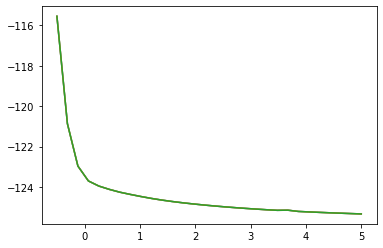

In [64]:
plot_energy_landscape(e_s_result)

Note that all the different optimizers and the Hartree-Fock approximation gives the same result, indicating a high-chance that the result is correct

In [ ]:
vqe.print_settings()